In [14]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

In [15]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


In [16]:
#############################################
### MAKE A LIST OF IMAGE NAMES TO READ IN ###
#############################################

# list of file names to analyze
images = ["Col-0_3UF.JPG",
          "Ull2-3_39UF.JPG"
         ]

# number of plants
num_plants = len(images)

# list of pixels per centimeter for each image
px_cm_list = [468,
              466.017
             ]

# list of genotypes based on file names
genotypes = []
for i in images:
    genotypes.append(i[0:images[0].index("_")])


# Image processing, landmarking, scaling

In [17]:
######################
### SET PARAMETERS ###
######################

gauss = 51 # size of Gaussian blur kernel window, must be positive and odd
ker = 5 # size of dilation/erosion kernel window
iterations = 1 # number of dilations/erosions
res = 50 # resolution to interpolate points on each side of leaf
target_ang = 90 # angle to rotate leaf to
num_leaves = 5 # number of leaves per image
inter_tip_ind = 51 # the index of the tip in the interpolated leaf

# arrays to store leaves are as follows:
# number of plants x
# number of leaves x
# x and y coordinates
# number of points

leaves_cm_arr = np.zeros((num_plants, num_leaves, 2, res*2)) # array of leaves in cm
leaves_scale_arr = np.zeros((num_plants, num_leaves, 2, res*2)) # array of scaled leaves

for i in range(num_plants):

    curr_image = images[i] # select current image
    px_cm = px_cm_list[i] # select current px per cm value
    leaf_ind = i # store the index for saving data at end
    
    print(curr_image)

    ########################
    ### IMAGE PROCESSING ###
    ########################

    img = cv2.flip(cv2.cvtColor(cv2.imread(curr_image),cv2.COLOR_BGR2GRAY),0) # convert to grayscale, flip vertically
    blur = cv2.GaussianBlur(img,(gauss,gauss),0) # apply Gaussian blue
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # threshold to binary
    invbin = cv2.bitwise_not(thresh) # invert the binary
    kernel = np.ones((ker,ker),np.uint8)  # define kernel for dilation/erosion
    dilation_img = cv2.dilate(invbin,kernel,iterations = iterations) # dilate
    erode_img = cv2.erode(dilation_img,kernel,iterations = iterations) # erode

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(erode_img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    ############################
    ### FIND LARGEST OBJECTS ###
    ############################

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:num_leaves] # top areas x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:num_leaves] # top areas y vals

    ###########################
    ### ORDER LEFT TO RIGHT ###
    ###########################  

    x_means = [] # store mean x values of largest leaves
    for lf in sorted_x_conts: # for the largest objects/leaves
        x_means.append(np.mean(lf)) # append mean x val of current leaf

    order_inds =np.argsort(x_means) # get indices to order leaves left to right
    ordered_x_leaves = np.array(sorted_x_conts, dtype=object)[order_inds] # leaf x vals, left to right
    ordered_y_leaves = np.array(sorted_y_conts, dtype=object)[order_inds] # leaf y vals, left to right

    ##########################
    ### INTERPOLATE LEAVES ###
    ##########################

    inter_arr = np.zeros((num_leaves,2,res*2)) # 3D array, 5 leaves by x and y vals by number of points

    for lf in range(5): # for each of the 5 leaves

        curr_lf_x = ordered_x_leaves[lf] # select current leaf x vals
        curr_lf_y = ordered_y_leaves[lf] # select current leaf y vals

        dist_ori = [] # store distance to origin (leaf base) for each point
        for pt in range(len(curr_lf_x)):
            dist_ori.append(euclid_dist(curr_lf_x[0],curr_lf_y[0],curr_lf_x[pt],curr_lf_y[pt]))

        tip_ind = dist_ori.index(max(dist_ori)) # set tip index as farthest from the base

        left_inter_x, left_inter_y = interpolation(curr_lf_x[:tip_ind],curr_lf_y[:tip_ind], res) # interpolate left side, base to tip
        right_inter_x, right_inter_y = interpolation(curr_lf_x[tip_ind:-1],curr_lf_y[tip_ind:-1], res) # interpolate right side, tip to base

        inter_xvals = np.concatenate((left_inter_x, right_inter_x)) # concatenate x vals
        inter_yvals = np.concatenate((left_inter_y, right_inter_y)) # concatenate y vals

        inter_arr[lf,:,:] = np.row_stack((inter_xvals, inter_yvals))/px_cm # create a 2 x res array, x/y vals first followed by points for each leaf in cm

    ###############################
    ### ROTATE AND SCALE LEAVES ###
    ###############################

    cm_arr = np.zeros((num_leaves,2,res*2)) # 5 leaves by x/y vals by number of points for cm leaves
    scale_arr = np.zeros((num_leaves,2,res*2)) # 5 leaves by x/y vals by number of points for scaled leaves

    for lf in range(5): # for each of the 5 leaves

        base_curr_lf = inter_arr[lf,:,0] # get base point of current leaf
        tip_curr_lf = inter_arr[lf,:,inter_tip_ind] # get tip point of current leaf

        ang = angle_between(tip_curr_lf, base_curr_lf, (base_curr_lf[0]+1,base_curr_lf[1]) ) # get leaf angle
        rot_x, rot_y = rotate_points(inter_arr[lf,0,:], inter_arr[lf,1,:], ang) # rotate leaf upwards
        trans_x, trans_y = rot_x - rot_x[0], -(rot_y - rot_y[0]) # translate leaf base to origin, in cm
        scale_x, scale_y = trans_x/trans_y[inter_tip_ind], trans_y/trans_y[inter_tip_ind] # scale length to 1

        cm_arr[lf,:,:] = np.row_stack((trans_x, trans_y)) # create a 2 x res array in cm, x/y vals first followed by points for each leaf
        scale_arr[lf,:,:] = np.row_stack((scale_x, scale_y)) # create a 2 x res array in cm, x/y vals first followed by points for each leaf
        
    ##################
    ### STORE DATA ###
    ##################
    
    leaves_cm_arr[leaf_ind,:,:,:] = cm_arr
    leaves_scale_arr[leaf_ind,:,:,:] = scale_arr
    


Col-0_3UF.JPG
Ull2-3_39UF.JPG


# Analyze leaf dimensions

In [18]:
dim_geno = []
dim_node = []
dim_len = []
dim_wid = []
dim_area = []

for plant in range(num_plants):
    for lf in range(num_leaves):

        curr_lf = leaves_cm_arr[plant,lf] # select current leaf
        geno = genotypes[plant] # get genotype

        if lf==0: # get node number
            node=3
        elif lf==1:
            node=4
        elif lf==2:
            node=5
        elif lf==3:
            node=6
        else:
            node=7

        width = np.max(curr_lf[0])-np.min(curr_lf[0]) # calculate width
        length = np.max(curr_lf[1])-np.min(curr_lf[1]) # calculate length
        area = poly_area(curr_lf[0],curr_lf[1]) # calcualte area
        
        # store data
        dim_geno.append(geno)
        dim_node.append(node)
        dim_len.append(length)
        dim_wid.append(width)
        dim_area.append(area)
        
# create a dataframe for plotting
dim_df = pd.DataFrame(data={"genotype":dim_geno,
                            "node":dim_node,
                            "length":dim_len,
                            "width":dim_wid,
                            "area":dim_area
                           })

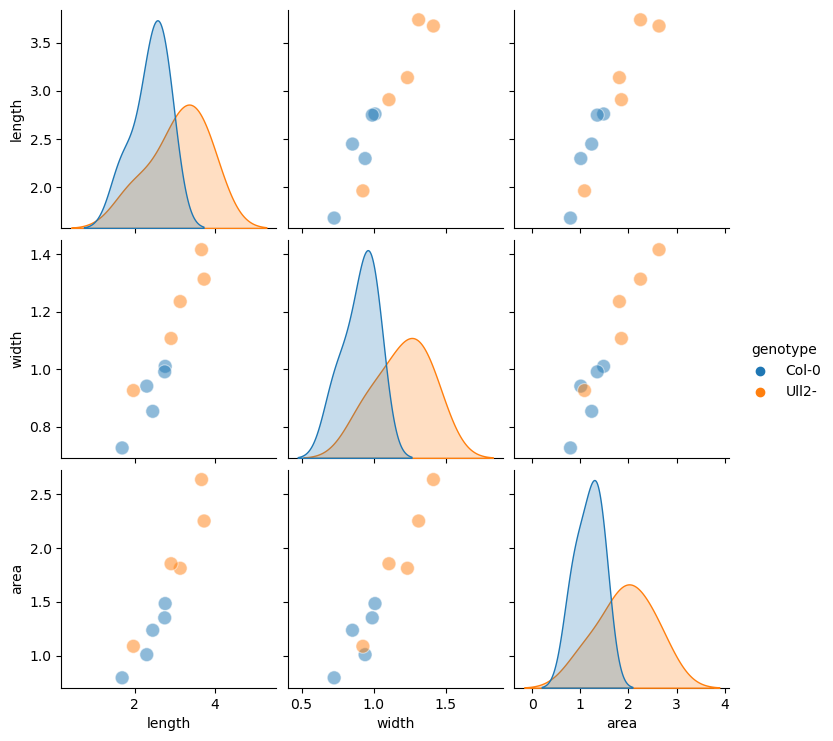

In [19]:
sns.pairplot(dim_df,
             x_vars=["length", "width", "area"],
             y_vars=["length", "width", "area"],
             hue="genotype",
             plot_kws={"s": 100, "alpha":0.5, "lw":0}
            )

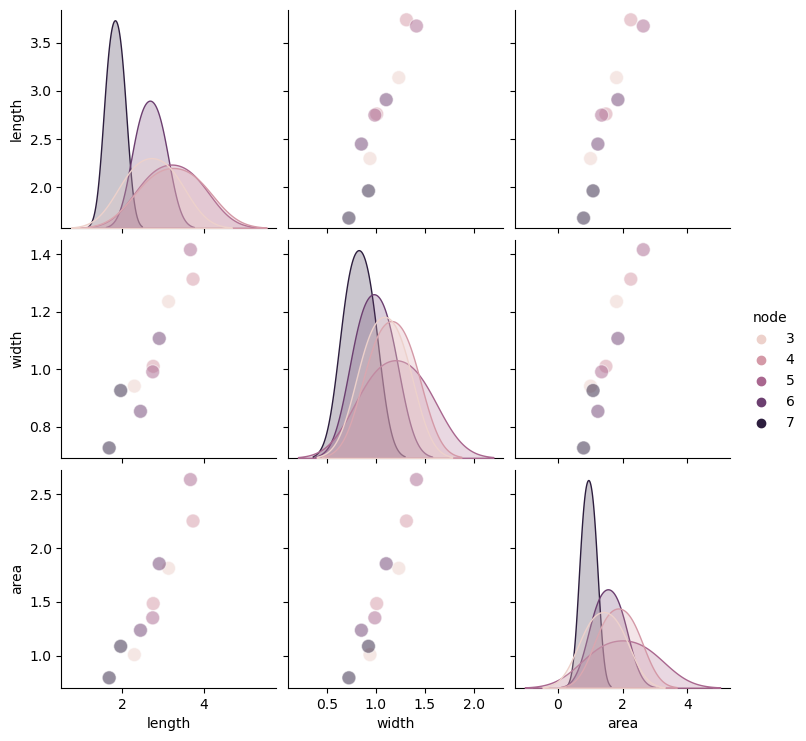

In [20]:
sns.pairplot(dim_df,
             x_vars=["length", "width", "area"],
             y_vars=["length", "width", "area"],
             hue="node",
             plot_kws={"s": 100, "alpha":0.5, "lw":0}
            )

# Morphospace

In [21]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 10 
#######

reshape_scale = leaves_scale_arr.reshape(num_plants*num_leaves, 2*res*2) # use the reshape function to flatten to 2D

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(reshape_scale) # fit a PCA for all data

print(pca_all.explained_variance_ratio_) # print out explained variance for each PC
print(pca_all.explained_variance_ratio_.cumsum())


[5.18000491e-01 3.68015069e-01 5.87980235e-02 2.83211623e-02
 1.24398597e-02 8.53231185e-03 3.12261377e-03 1.60754115e-03
 1.16292822e-03 3.45895392e-30]
[0.51800049 0.88601556 0.94481358 0.97313475 0.98557461 0.99410692
 0.99722953 0.99883707 1.         1.        ]


In [22]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshape_scale) # fit a PCA for only desired PCs

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())

# create dataframe for plotting
pca_df = pd.DataFrame(data={"genotype":dim_geno,
                            "node":dim_node,
                            "PC1":PCs[:,0],
                            "PC2":PCs[:,1]
                           })

[0.51800049 0.36801507]
[0.51800049 0.88601556]


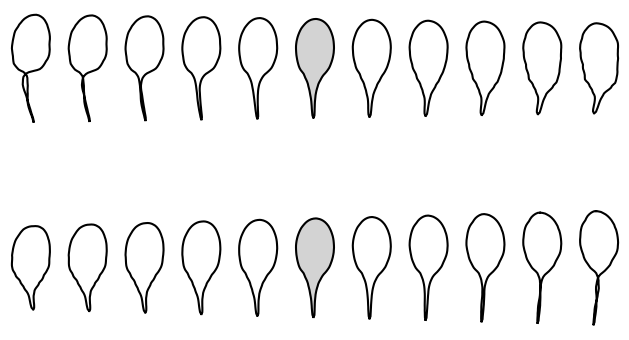

In [23]:
##########################
### CREATE EIGENLEAVES ###
##########################

pc1_n25 = pca.inverse_transform(np.array([-2.5*np.std(PCs[:,0]),0]))
pc1_n20 = pca.inverse_transform(np.array([-2.0*np.std(PCs[:,0]),0]))
pc1_n15 = pca.inverse_transform(np.array([-1.5*np.std(PCs[:,0]),0]))
pc1_n10 = pca.inverse_transform(np.array([-1.0*np.std(PCs[:,0]),0]))
pc1_n05 = pca.inverse_transform(np.array([-0.5*np.std(PCs[:,0]),0]))
pc1_n00 = pca.inverse_transform(np.array([0*np.std(PCs[:,0]),0]))
pc1_p25 = pca.inverse_transform(np.array([2.5*np.std(PCs[:,0]),0]))
pc1_p20 = pca.inverse_transform(np.array([2.0*np.std(PCs[:,0]),0]))
pc1_p15 = pca.inverse_transform(np.array([1.5*np.std(PCs[:,0]),0]))
pc1_p10 = pca.inverse_transform(np.array([1.0*np.std(PCs[:,0]),0]))
pc1_p05 = pca.inverse_transform(np.array([0.5*np.std(PCs[:,0]),0]))

pc2_n25 = pca.inverse_transform(np.array([0,-2.5*np.std(PCs[:,1])]))
pc2_n20 = pca.inverse_transform(np.array([0,-2.0*np.std(PCs[:,1])]))
pc2_n15 = pca.inverse_transform(np.array([0,-1.5*np.std(PCs[:,1])]))
pc2_n10 = pca.inverse_transform(np.array([0,-1.0*np.std(PCs[:,1])]))
pc2_n05 = pca.inverse_transform(np.array([0,-0.5*np.std(PCs[:,1])]))
pc2_n00 = pca.inverse_transform(np.array([0,0*np.std(PCs[:,1])]))
pc2_p25 = pca.inverse_transform(np.array([0,2.5*np.std(PCs[:,1])]))
pc2_p20 = pca.inverse_transform(np.array([0,2.0*np.std(PCs[:,1])]))
pc2_p15 = pca.inverse_transform(np.array([0,1.5*np.std(PCs[:,1])]))
pc2_p10 = pca.inverse_transform(np.array([0,1.0*np.std(PCs[:,1])]))
pc2_p05 = pca.inverse_transform(np.array([0,0.5*np.std(PCs[:,1])]))

outl = "k" # outline color
fillc = "lightgray" # fill color of mean

plt.subplot(2,11,1)
plt.plot(pc1_n25[:2*res],pc1_n25[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,2)
plt.plot(pc1_n20[:2*res],pc1_n20[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,3)
plt.plot(pc1_n15[:2*res],pc1_n15[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,4)
plt.plot(pc1_n10[:2*res],pc1_n10[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,5)
plt.plot(pc1_n05[:2*res],pc1_n05[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,6)
plt.plot(pc1_n00[:2*res],pc1_n00[2*res:],c=outl)
plt.fill(pc1_n00[:2*res],pc1_n00[2*res:],c=fillc)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,7)
plt.plot(pc1_p05[:2*res],pc1_p05[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,8)
plt.plot(pc1_p10[:2*res],pc1_p10[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,9)
plt.plot(pc1_p15[:2*res],pc1_p15[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,10)
plt.plot(pc1_p20[:2*res],pc1_p20[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,11)
plt.plot(pc1_p25[:2*res],pc1_p25[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,12)
plt.plot(pc2_n25[:2*res],pc2_n25[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,13)
plt.plot(pc2_n20[:2*res],pc2_n20[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,14)
plt.plot(pc2_n15[:2*res],pc2_n15[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,15)
plt.plot(pc2_n10[:2*res],pc2_n10[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,16)
plt.plot(pc2_n05[:2*res],pc2_n05[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,17)
plt.plot(pc2_n00[:2*res],pc2_n00[2*res:],c=outl)
plt.fill(pc2_n00[:2*res],pc2_n00[2*res:],c=fillc)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,18)
plt.plot(pc2_p05[:2*res],pc2_p05[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,19)
plt.plot(pc2_p10[:2*res],pc2_p10[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,20)
plt.plot(pc2_p15[:2*res],pc2_p15[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,21)
plt.plot(pc2_p20[:2*res],pc2_p20[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(2,11,22)
plt.plot(pc2_p25[:2*res],pc2_p25[2*res:],c=outl)
plt.gca().set_aspect("equal")
plt.axis("off")


plt.tight_layout()

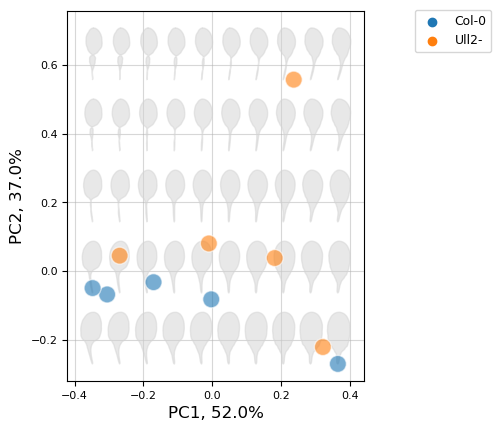

In [24]:
##########################
### CREATE MORPHOSPACE ###
##########################

numPC1 = 10 # set PC1 intervals
numPC2 = 5 # set PC2 intervals

hue = "genotype" # select the factor to color by

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

s = 0.15 # set the scale

for i in PC1_vals:
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[:res*2]
        inv_y = inv_leaf[res*2:]
        
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c="lightgray", alpha=0.5)
        
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=hue, s=150, lw=0, alpha=0.6)

plt.legend(bbox_to_anchor=(1.15, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],2)*100) + "%"
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],2)*100) + "%"
plt.xlabel(xlab, fontsize=12)
plt.ylabel(ylab, fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor("white")
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)
